###**Generative Adversarial Networks <br>**

(Riya Arora)


---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [123]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import os
import kagglehub

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda





---


##### **Part A: Implement standard GAN on MNIST data.**

**Dataset Preparation**

In [124]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor(), download=True
)

In [125]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 1 Batch is like
for images, labels in train_loader:
    print(images.shape)
    break

torch.Size([32, 1, 28, 28])


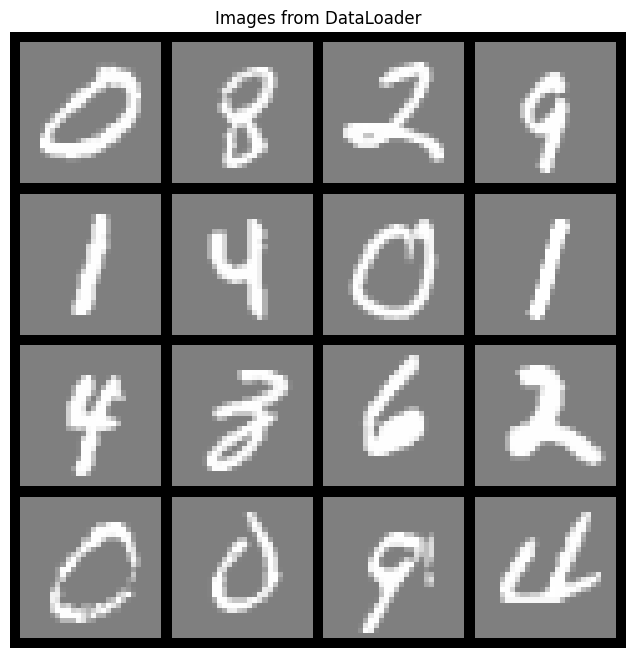

In [126]:
# Displaying MNIST messages
dataiter = iter(train_loader)
images, labels = next(dataiter)

def denormalize(img):
    img = img * 0.5 + 0.5
    return img

images = denormalize(images)

grid = make_grid(images[:16], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis("off")
plt.title("Images from DataLoader")
plt.show()


**Model Set-Up**

In [128]:
# Fully connected layers generator didn't work well, thus new generator with below architecture has been used

# class Generator(nn.Module):
#     def __init__(self, z_dim):
#         super(Generator, self).__init__()

#         # Using only fully connected layers for now
#         # Hoping for results because MNIST dataset should be simple enough
#         # Will try later with linear + deconvolutional layers
#         self.fc1 = nn.Linear(z_dim, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.fc2 = nn.Linear(256, 512)
#         self.bn2 = nn.BatchNorm1d(512)
#         self.fc3 = nn.Linear(512, 1024)
#         self.bn3 = nn.BatchNorm1d(1024)
#         self.fc4 = nn.Linear(1024, 28*28)
#         self.tanh = nn.Tanh()

#     def forward(self, z):
#         z = torch.relu(self.bn1(self.fc1(z)))
#         z = torch.relu(self.bn2(self.fc2(z)))
#         z = torch.relu(self.bn3(self.fc3(z)))
#         z = self.fc4(z)
#         z = z.view(z.size(0), 1, 28, 28)
#         return self.tanh(z)

In [129]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(z_dim, 7 * 7 * 128),
            nn.BatchNorm1d(7 * 7 * 128),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [130]:
# This discriminator was too strong for the generator to learn, thus introduced less layers and dropout in the below architecture.

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         # Using only fully-connected layers for now
#         self.fc1 = nn.Linear(28*28, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = F.leaky_relu(self.fc1(x), 0.2)
#         x = F.leaky_relu(self.fc2(x), 0.2)
#         x = F.leaky_relu(self.fc3(x), 0.2)
#         x = self.fc4(x)
#         x = self.sigmoid(x)
#         return x

In [131]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout2(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [132]:
# Weight initialization
def xavier_weights_init(m):
    if isinstance(m, nn. Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [133]:
# Simulating a run of input through the model (Not training yet)

z_dim = 100
batch_size = 32
generator = Generator(z_dim)
discriminator = Discriminator()

generator.apply(xavier_weights_init)
discriminator.apply(xavier_weights_init)

random_noise_input = torch.randn(batch_size, z_dim)
generated_images = generator(random_noise_input)
generated_images = generated_images.view(generated_images.size(0), -1)

real_images, _ = next(iter(train_loader))
real_images = real_images.view(real_images.size(0), -1)

real_output = discriminator(real_images)
fake_output = discriminator(generated_images)

print(real_output)
print(fake_output)

tensor([[0.5407],
        [0.4521],
        [0.3746],
        [0.2401],
        [0.2980],
        [0.4382],
        [0.3548],
        [0.4655],
        [0.3983],
        [0.2921],
        [0.4692],
        [0.4355],
        [0.2910],
        [0.4320],
        [0.3883],
        [0.4038],
        [0.4396],
        [0.3847],
        [0.2358],
        [0.4290],
        [0.3649],
        [0.3061],
        [0.1910],
        [0.3777],
        [0.3304],
        [0.3495],
        [0.2382],
        [0.4601],
        [0.4371],
        [0.3105],
        [0.4291],
        [0.4709]], grad_fn=<SigmoidBackward0>)
tensor([[0.3685],
        [0.5925],
        [0.7416],
        [0.4492],
        [0.3264],
        [0.5372],
        [0.2421],
        [0.3572],
        [0.2941],
        [0.3870],
        [0.2374],
        [0.3837],
        [0.3074],
        [0.1438],
        [0.4943],
        [0.2307],
        [0.3576],
        [0.4152],
        [0.5472],
        [0.1710],
        [0.4636],
        [0.4384],

**Introducing Loss Functions**

In [136]:
# Introducing generator loss function

z_dim = 100
batch_size = 32
bce_loss = nn.BCELoss()
real_label = 0.9 # Trying with smoothening
fake_label = 0.0

g1 = Generator(z_dim).to(device)
g1.apply(xavier_weights_init)
d1 = Discriminator().to(device)
d1.apply(xavier_weights_init)

real_images, _ = next(iter(train_loader))
real_images = real_images.to(device).view(real_images.size(0), -1)
real_output = d1(real_images)
d1_real_loss = bce_loss(real_output, torch.full((batch_size, 1), real_label, device = device))

random_noise_input = torch.randn(batch_size, z_dim, device = device)
generated_images = g1(random_noise_input)
generated_images = generated_images.view(generated_images.size(0), -1)
fake_output = d1(generated_images.detach())
d1_fake_loss = bce_loss(fake_output, torch.full((batch_size, 1), fake_label, device = device))

d1_total_loss = d1_real_loss + d1_fake_loss

In [137]:
# Introducing discriminator loss function

fake_output = d1(generated_images)
g1_total_loss = bce_loss(fake_output, torch.full((batch_size, 1), real_label, device = device))


**GAN Training**

In [145]:
# Setting the hyperparameters

z_dim = 100
batch_size = 64
lr = 0.0001
d_lr = 0.00002
momentum = 0.5
epochs = 200

In [146]:
# Model, Optimizers and Loss

G = Generator(z_dim).to(device)
D = Discriminator().to(device)
G.apply(xavier_weights_init)
D.apply(xavier_weights_init)

G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(momentum, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(momentum, 0.999))

torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)

bce_loss = nn.BCELoss()

In [147]:
# Metrics through the epochs
G_losses = []
D_losses = []
D_accuracies = []

In [148]:
# Saving and Loading Checkpoints

import torch

def save_checkpoint(epoch, g_model, d_model, g_optimizer, d_optimizer,checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'g_model_state_dict': g_model.state_dict(),
        'd_model_state_dict': d_model.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} to {checkpoint_path}")

def load_checkpoint(checkpoint_path, g_model, d_model, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g_model.load_state_dict(checkpoint['g_model_state_dict'])
    d_model.load_state_dict(checkpoint['d_model_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    epoch = checkpoint['epoch']

    print(f"Checkpoint loaded from epoch {epoch} from {checkpoint_path}")
    return epoch

In [149]:
# Training
update_var = 0
checkpoint_path = '/content/drive/MyDrive/gen-ai/gan-results/gan_ckpt.pth'
for epoch in range(epochs):
    for real_images, _ in train_loader:
        real_images = real_images.to(device).view(real_images.size(0), -1)

        real_labels = torch.full((real_images.size(0), 1), 0.8, device=device)
        fake_labels = torch.full((real_images.size(0), 1), 0.2, device=device)
        # Discriminator part

        real_output = D(real_images)
        D_real_loss = bce_loss(real_output, real_labels)

        random_noise = torch.randn(real_images.size(0), z_dim, device=device)
        generated_images = G(random_noise)
        fake_output = D(generated_images.detach())
        D_fake_loss = bce_loss(fake_output, fake_labels)
        D_total_loss = D_real_loss + D_fake_loss

        if (update_var == 0):
          D_optimizer.zero_grad()
          D_total_loss.backward()
          D_optimizer.step()

        # Calculate discriminator accuracy
        real_correct = (real_output > 0.5).float().sum().item()
        fake_correct = (fake_output < 0.5).float().sum().item()

        # Total samples
        real_total = real_images.size(0)
        fake_total = generated_images.size(0)

        # Average accuracy
        D_accuracy = (real_correct + fake_correct) / (real_total + fake_total)


        random_noise = torch.randn(real_images.size(0), z_dim, device=device)
        fake_labels.fill_(1.0)
        generated_images = G(random_noise)
        fake_output = D(generated_images)
        G_loss = bce_loss(fake_output, fake_labels)

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_total_loss.item())
        D_accuracies.append(D_accuracy)

        update_var = (update_var + 1) % 5

    # Save checkpoint at intervals
    if (epoch % 10 == 0 or epoch == (epochs-1)):
        save_checkpoint(epoch, G, D, G_optimizer, D_optimizer, checkpoint_path)

    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}]  D Loss: {D_total_loss.item():.4f}  G Loss: {G_loss.item():.4f} D Accuracy: {D_accuracy:.4f}")


Checkpoint saved at epoch 0 to /content/drive/MyDrive/gen-ai/gan-results/gan_ckpt.pth
Epoch [1/200]  D Loss: 1.6325  G Loss: 0.6390 D Accuracy: 0.3125
Epoch [2/200]  D Loss: 1.5055  G Loss: 0.6410 D Accuracy: 0.3281
Epoch [3/200]  D Loss: 1.4554  G Loss: 0.6639 D Accuracy: 0.3125
Epoch [4/200]  D Loss: 1.4484  G Loss: 0.6444 D Accuracy: 0.4062
Epoch [5/200]  D Loss: 1.4227  G Loss: 0.6958 D Accuracy: 0.4375
Epoch [6/200]  D Loss: 1.4440  G Loss: 0.6799 D Accuracy: 0.4062
Epoch [7/200]  D Loss: 1.4030  G Loss: 0.6670 D Accuracy: 0.4844
Epoch [8/200]  D Loss: 1.4126  G Loss: 0.6780 D Accuracy: 0.4375
Epoch [9/200]  D Loss: 1.4123  G Loss: 0.6441 D Accuracy: 0.3594
Epoch [10/200]  D Loss: 1.4085  G Loss: 0.6837 D Accuracy: 0.3281
Checkpoint saved at epoch 10 to /content/drive/MyDrive/gen-ai/gan-results/gan_ckpt.pth
Epoch [11/200]  D Loss: 1.4050  G Loss: 0.6904 D Accuracy: 0.5312
Epoch [12/200]  D Loss: 1.3794  G Loss: 0.6930 D Accuracy: 0.5938
Epoch [13/200]  D Loss: 1.3927  G Loss: 0.69

In [156]:
print(len(G_losses))
print(len(D_losses))
print(len(D_accuracies))

375000
375000
375000


In [157]:
# Saving metrics to disk

metrics_df = pd.DataFrame({
    "g_losses": G_losses,
    "d_losses": D_losses,
    "d_accuracies": D_accuracies
})

metrics_save_path = '/content/drive/MyDrive/gen-ai/gan-results/metrics.csv'
metrics_df.to_csv(metrics_save_path, index=False)

In [158]:
# Reading metrics from disk

metrics_read_path = '/content/drive/MyDrive/gen-ai/gan-results/metrics.csv'
metrics_df = pd.read_csv(metrics_read_path)

G_losses = metrics_df["g_losses"].tolist()
D_losses = metrics_df["d_losses"].tolist()
D_accuracies = metrics_df["d_accuracies"].tolist()
print(D_accuracies[:100])

[0.515625, 0.578125, 0.53125, 0.5, 0.5625, 0.46875, 0.5, 0.5, 0.46875, 0.5, 0.46875, 0.484375, 0.484375, 0.46875, 0.53125, 0.453125, 0.5, 0.515625, 0.515625, 0.453125, 0.4375, 0.515625, 0.53125, 0.453125, 0.46875, 0.484375, 0.5, 0.484375, 0.515625, 0.46875, 0.5, 0.484375, 0.5, 0.46875, 0.484375, 0.5, 0.453125, 0.484375, 0.484375, 0.5, 0.453125, 0.515625, 0.484375, 0.484375, 0.484375, 0.4375, 0.46875, 0.515625, 0.421875, 0.484375, 0.5, 0.5, 0.484375, 0.484375, 0.515625, 0.484375, 0.4375, 0.5, 0.5, 0.484375, 0.46875, 0.53125, 0.46875, 0.5, 0.46875, 0.46875, 0.453125, 0.421875, 0.4375, 0.5, 0.46875, 0.484375, 0.5, 0.46875, 0.484375, 0.484375, 0.453125, 0.484375, 0.515625, 0.484375, 0.40625, 0.5625, 0.5, 0.453125, 0.453125, 0.5, 0.5, 0.484375, 0.515625, 0.484375, 0.515625, 0.515625, 0.421875, 0.484375, 0.46875, 0.515625, 0.5, 0.53125, 0.5, 0.4375]


In [159]:
print(len(train_loader))

1875


In [160]:
group_size = 1875

average_loss = []
for i in range(0, len(D_accuracies), group_size):
    chunk = D_accuracies[i:i + group_size]
    chunk_average = sum(chunk) / len(chunk)
    average_loss.append(chunk_average)

print(average_loss)

[0.3178, 0.28475833333333334, 0.29965, 0.3339416666666667, 0.368575, 0.39974166666666666, 0.4161916666666667, 0.42620833333333336, 0.4363666666666667, 0.4454, 0.45941666666666664, 0.46553333333333335, 0.46425833333333333, 0.46758333333333335, 0.4683083333333333, 0.47179166666666666, 0.4759583333333333, 0.4792166666666667, 0.47936666666666666, 0.481675, 0.4811166666666667, 0.4835583333333333, 0.48573333333333335, 0.4845, 0.48789166666666667, 0.485975, 0.4873416666666667, 0.48833333333333334, 0.48894166666666666, 0.49004166666666665, 0.4908416666666667, 0.4897666666666667, 0.49406666666666665, 0.49135833333333334, 0.493275, 0.490225, 0.49183333333333334, 0.49480833333333335, 0.495925, 0.49411666666666665, 0.4956083333333333, 0.495425, 0.49695833333333334, 0.49430833333333335, 0.495725, 0.49455, 0.4971, 0.4979166666666667, 0.4960833333333333, 0.4967083333333333, 0.49855, 0.5007583333333333, 0.498025, 0.49861666666666665, 0.49928333333333336, 0.49851666666666666, 0.5008833333333333, 0.5011

<ipython-input-166-25a8e672bc80>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path)


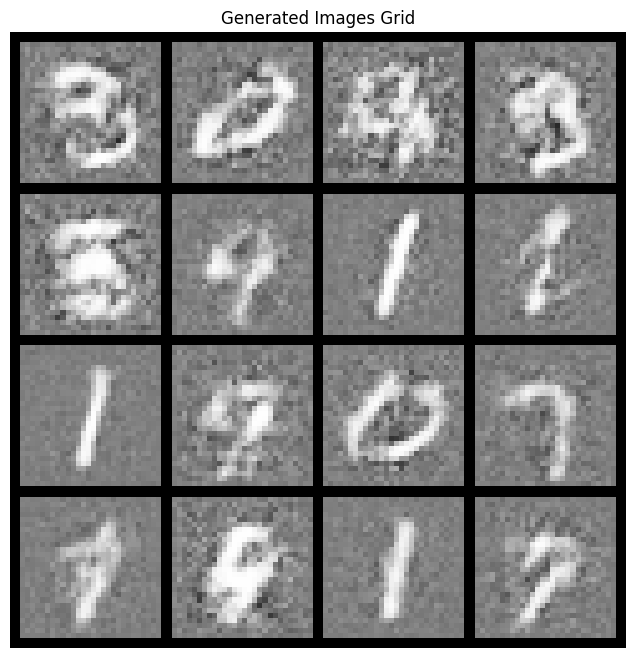

In [166]:
# Trying to generate images with GAN (with denormalization)

num_images = 16
ckpt = torch.load(checkpoint_path)
G.load_state_dict(ckpt['g_model_state_dict'])
G.eval()

random_noise = torch.randn(num_images, z_dim, device=device)
generated_images = G(random_noise)
# print(generated_images.min().item(), generated_images.max().item())
generated_images = (generated_images + 1) / 2
generated_images = generated_images.view(num_images, 1, 28, 28).detach().cpu()

grid = make_grid(generated_images, nrow=4, padding=2, normalize=False)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')  # Convert to HWC for plotting
plt.axis('off')
plt.title("Generated Images Grid")
plt.show()